In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Identifying Marker Transcripts
Here, we'll look for genes expressed by **Phaeocystis globosa** that correlate well with the patterns in O2, to find out if the functions of those genes are related to metabolic processes that are involved in the observed patterns. For this, we've run the script [get_marker_transcripts.py](get_marker_transcripts.py) on the HPC (by submitting [submit_marker_detection.pbs](submit_marker_detection.pbs)), wheret we fit a generalised least squares (GLS) model for every transcript in the **Phaeocystis** transcriptome. The script outputs a list of transcripts that are significantly correlated with the first derivative of the residuals in O2, after accounting for physical variation. We'll load this list and look at the functional annotation for the corresponding gene names in the **Phaeocystis** transcriptome. 

In [3]:
# Load the phaeocystis transcriptome bin
phaeo_transcriptome = pd.read_csv('../data/annotation/taxonomy_eukprot/130/genus_bins/Phaeocystis_transcriptome_bin.csv')

# Load the marker gene data
marker_genes = pd.read_csv('../data/analysis/significant_derivative_markers.csv')

# Load the functional annotation data
functional_annotation = pd.read_table('../data/annotation/functional_eggnog/130/functional_annotation.emapper.annotations')
# Cut off weird characters from the transcript names
functional_annotation['#query'] = functional_annotation['#query'].str.split(".", n=1, expand=True)[0]
# Rename the query_id column
functional_annotation.rename(columns={'#query': 'query_id'}, inplace=True)

# Combine the marker genes with the functional annotation
marker_genes = marker_genes.merge(functional_annotation, on='query_id', how='left')

# Read TPL data
TPL = pd.read_csv('../data/quantification/130/130_tpl.csv')

# Calculate the total TPL for Phaeocystis per sample
phaeo_total = TPL[TPL['target_id'].isin(phaeo_transcriptome['query_id'])].melt(id_vars='target_id', var_name='sample', value_name='TPL')
## Generate Phaeocystis TPL sums per sample
phaeo_total = phaeo_total.groupby('sample')['TPL'].sum().reset_index()
## Rename columns
phaeo_total.columns = ['sample', 'Phaeocystis_total_TPL']

# Only keep the TPL data for the marker genes
marker_TPL = TPL[TPL['target_id'].isin(marker_genes['query_id'])].melt(id_vars='target_id', var_name='sample', value_name='TPL')
# Add standardized TPL values to the marker genes, by dividing by the total Phaeocystis TPL
marker_TPL = marker_TPL.merge(phaeo_total, on='sample', how='left')
marker_TPL['TPL_standardized'] = marker_TPL['TPL'] / marker_TPL['Phaeocystis_total_TPL']

# Read the metadata
meta = pd.read_csv('../data/samples_env.csv')

# Add metadata
marker_TPL = marker_TPL.merge(meta, left_on='sample', right_on='Station', how='left')

# Add Z-scores of the standardized TPL values
marker_TPL['TPL_standardized_z'] = (marker_TPL['TPL_standardized'] - marker_TPL['TPL_standardized'].mean()) / marker_TPL['TPL_standardized'].std()

In [8]:
# Sort marker genes by the absolute value of the O2 coefficient
marker_genes = marker_genes.reindex(marker_genes['dO2_resid_dt_coef'].abs().sort_values(ascending=False).index)

In [9]:
marker_genes.head()

,query_id,dO2_resid_dt_coef,dO2_resid_dt_pval,AIC,dO2_resid_dt_pval_adj,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
20,c_000003320975,0.000332,0.000080,-615.895974,0.047420,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,c_000004395896,0.000237,0.000031,-626.512957,0.038993,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c_000000548955,0.000080,0.000043,-736.917378,0.047420,2903.EOD35534,5.990000e-61,211.0,"COG0451@1|root,KOG1429@2759|Eukaryota",2759|Eukaryota,...,ko:K10046,"ko00053,ko00520,ko01100,ko01110,map00053,map00...",M00114,"R00889,R07672,R07673","RC00289,RC00403,RC01780","ko00000,ko00001,ko00002,ko01000",-,-,-,"Epimerase,Glycos_transf_2"
6,c_000001488588,-0.000044,0.000090,-785.557809,0.049336,2903.EOD18340,2.099000e-192,602.0,"COG0369@1|root,KOG1158@2759|Eukaryota",2759|Eukaryota,...,ko:K02641,"ko00195,ko01100,map00195,map01100",-,-,-,"ko00000,ko00001,ko00194,ko01000",-,-,iRC1080.CRv4_Au5_s11_g2609_t1,NAD_binding_1
25,c_000003971661,0.000038,0.000062,-788.144014,0.047420,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
marker_genes.to_csv('../data/analysis/significant_markers_with_annotation.csv', index=False)

In [12]:
# Extract the markers positively correlated with O2
pos_markers = marker_genes[marker_genes['dO2_resid_dt_coef'] > 0]
pos_markers[['query_id', 'dO2_resid_dt_coef', 'dO2_resid_dt_pval_adj', 'KEGG_ko', 'Description']].to_csv('../data/analysis/pos_markers.csv', index=False)

# Display the descriptions of the positively correlated markers
pos_markers[~pos_markers['Description'].isna()][['Description']]

,Description
2,UDP-glucuronate decarboxylase activity
21,-
19,ATPase activity
30,DNA photolyase activity
22,Belongs to the class-I aminoacyl-tRNA syntheta...
11,3-isopropylmalate dehydratase activity
28,Surfeit locus protein 2 (SURF2)


In [14]:
# Extract the markers negatively correlated with O2
neg_markers = marker_genes[marker_genes['dO2_resid_dt_coef'] < 0]
neg_markers[['query_id', 'dO2_resid_dt_coef', 'dO2_resid_dt_pval_adj', 'KEGG_ko', 'Description']].to_csv('../data/analysis/neg_markers.csv', index=False)

# Display the descriptions of the negatively correlated markers, ignore NaNs and '-' descriptions
print = neg_markers[~neg_markers['Description'].isna()][['Description']]
print = print[print['Description'] != '-']
print

,Description
6,NADPH-hemoprotein reductase activity
10,prohibitin homologues
1,Chromate transporter
32,Putative tRNA binding domain
3,ribosomal protein import into nucleus
36,valyl-tRNA aminoacylation
12,regulation of endocannabinoid signaling pathway
4,Mitochondrial carrier protein
27,Mpv17 / PMP22 family


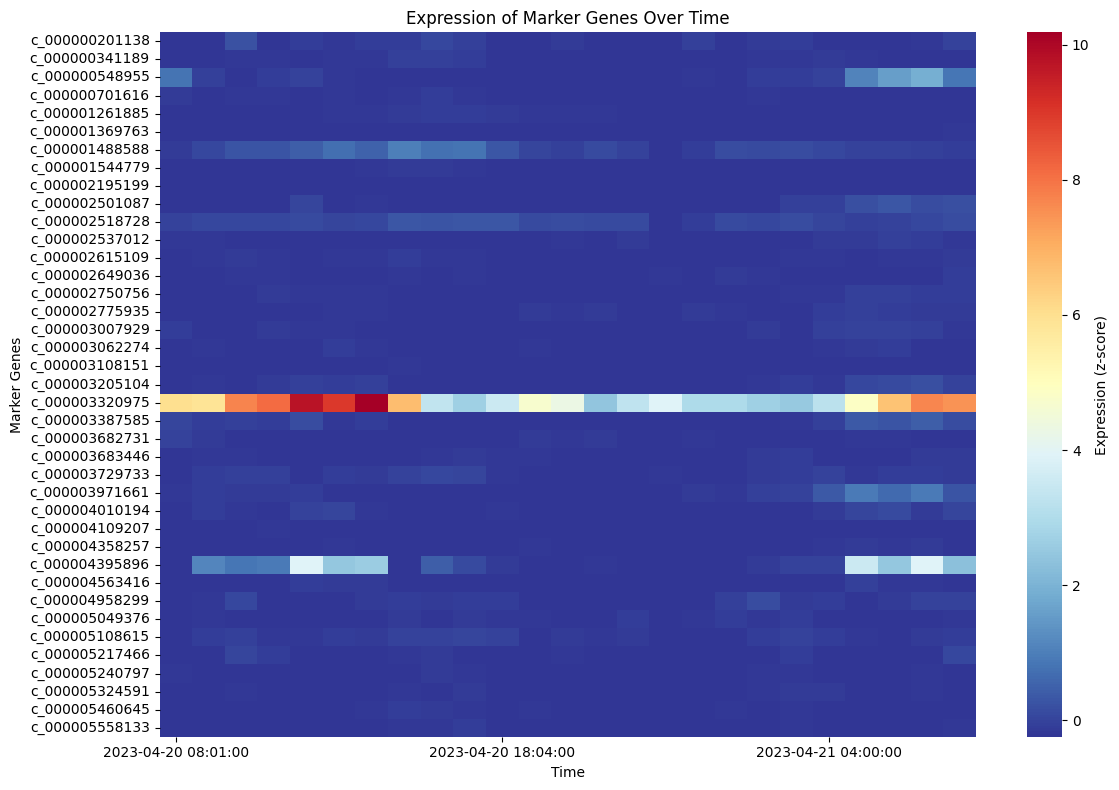

In [15]:
# Pivot for heatmap
heatmap_data = marker_TPL.pivot(index='target_id', columns='Date', values='TPL_standardized_z')

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='RdYlBu_r',
    xticklabels=10,  # Adjust frequency of time labels
    yticklabels=True,
    cbar_kws={'label': 'Expression (z-score)'}
)
plt.title('Expression of Marker Genes Over Time')
plt.xlabel('Time')
plt.ylabel('Marker Genes')
plt.tight_layout()
plt.show()